In [72]:
import os

import numpy as np
from scipy import signal as sig

import matplotlib.pyplot as plt

In [ ]:
?sig.convolve2d

Signature: sig.convolve2d(in1, in2, mode='full', boundary='fill', fillvalue=0)
Docstring:
Convolve two 2-dimensional arrays.

Convolve `in1` and `in2` with output size determined by `mode`, and
boundary conditions determined by `boundary` and `fillvalue`.

Parameters
----------
in1 : array_like
    First input.
in2 : array_like
    Second input. Should have the same number of dimensions as `in1`.
mode : str {'full', 'valid', 'same'}, optional
    A string indicating the size of the output:

    ``full``
       The output is the full discrete linear convolution
       of the inputs. (Default)
    ``valid``
       The output consists only of those elements that do not
       rely on the zero-padding. In 'valid' mode, either `in1` or `in2`
       must be at least as large as the other in every dimension.
    ``same``
       The output is the same size as `in1`, centered
       with respect to the 'full' output.
boundary : str {'fill', 'wrap', 'symm'}, optional
    A flag indicating how to

Build TORS using 2D convolution tor centres for given size.

In [ ]:
def kernel(ksize,arr):
    k = np.ones((ksize, ksize))
    arrc = sig.convolve2d(arr, k, mode='same', boundary='wrap')
    arrc[arrc >= 1] = 1
    
    return arrc

`ksize`: int, size of the kernel
`arr`: a 2d numpy array that represent the input data

GitHub Copilot: This code defines a function called `kernel` that takes two arguments: `ksize` and `arr`. The `ksize` argument is an integer that specifies the size of the kernel, and the `arr` argument is a two-dimensional numpy array that represents the input data.

The function first creates a kernel matrix `k` using the `np.ones` function, which creates a matrix of ones with the specified size. The `sig.convolve2d` function is then used to convolve the input array `arr` with the kernel `k`. The `mode` parameter is set to `'same'`, which means that the output will have the same shape as the input, and the `boundary` parameter is set to `'wrap'`, which means that the input is assumed to wrap around at the edges.

The resulting convolved array `arrc` is then thresholded so that any values greater than or equal to 1 are set to 1. Finally, the function returns the thresholded array `arrc`.

Overall, this function performs a simple image processing operation known as kernel convolution, which is commonly used in tasks such as edge detection and blurring. The function could be improved by adding more error checking and handling, such as checking that the input array is two-dimensional and that the kernel size is odd. Additionally, the function could be optimized for performance by using more efficient convolution algorithms or by parallelizing the computation.

In [53]:
def kernel(ksize: int, arr: np.ndarray) -> np.ndarray:
    """
    Applies a kernel convolution to a 2D numpy array.
    Tor centres to bedrock using scipy.signal.convolve2d

    Args:
        ksize (int): The size of the kernel. Must be a positive odd integer.
        arr (numpy.ndarray): The input 2D numpy array.

    Returns:
        numpy.ndarray: The thresholded output array.

    Raises:
        ValueError: If ksize is not a positive odd integer or arr is not a 2D numpy array.
    """
    if not isinstance(ksize, int) or ksize <= 0:
        raise ValueError("ksize must be a positive integer")
    if not isinstance(arr, np.ndarray) or arr.ndim != 2:
        raise ValueError("arr must be a 2D numpy array")
    
    
    k = np.ones((ksize, ksize))
    
    arrc = sig.convolve2d(arr, k, mode='same', boundary='wrap')
    arrc[arrc >= 1] = 1
    return arrc

In [65]:
def tor_location(length: int, frac: float, scale: int, seed_no: int) -> np.ndarray:
    """
    Generates a synthetic bedrock map using tor locations for a given bedrock fraction.

    Args:
        length (int): The lengthth of the output map.
        frac (float): The desired bedrock fraction.
        scale (int): The size of the kernel used for thresholding.
        seed_no (int): The random seed used for generating the map.

    Returns:
        numpy.ndarray: The thresholded output array.

    Raises:
        None.
    """
    ### For Debugging ###
    output = []

    # initialise the output array
    z = np.zeros((length, length))

    # Number of tor locations required to achieve the desired bedrock fraction
    # in a synthetic bedrock map of size length x length.
    # Size of the map, desired bedrock fraction, size of kernel used for thresholding.
    tor_no = int(length*length*(1-frac)/(scale**2))
    
    # initialise the iteration counter and the ratio
    i=1
    ratio=0.
    
    while ratio < 0.995 or ratio > 1.005:
        if i==1:
            tor_no = tor_no
        else:
            tor_no = round(tor_no*ratio)
        # tor density    
        tor_dens = tor_no/(length*length)
        
        z = np.zeros((length,length))
        np.random.seed(seed_no)
        # uniform over [0, 1)
        z += np.random.random_sample((length,length))         
        z[z <= (1-tor_dens)] = 0
        z[z > (1-tor_dens)] = 1
        z = kernel(ksize=scale, arr=z) 
        
        denom = np.sum(z)/(length**2)
        try:
            ratio = (1-frac)/denom
        except ZeroDivisionError:
            ratio = None
            
        #ratio = (1-frac)/(0.00000000001+np.sum(z)/(length**2))
        output.append((i, ratio))

        if i==50:
            break

        i+=1
    
    if ratio < 0.995 or ratio > 1.005:
        print('Did not converge in fifty iterations.')
    
    return z, output
#QXLsyQTj3qJJVuQ$

In [92]:
mat, out = tor_location(length=1000, frac=0.5, scale=10, seed_no=420)

In [93]:
out

[(1, 1.2770185193225672),
 (2, 1.0689630844288422),
 (3, 1.0188673862587394),
 (4, 1.0062042554390371),
 (5, 1.0018313477036023)]

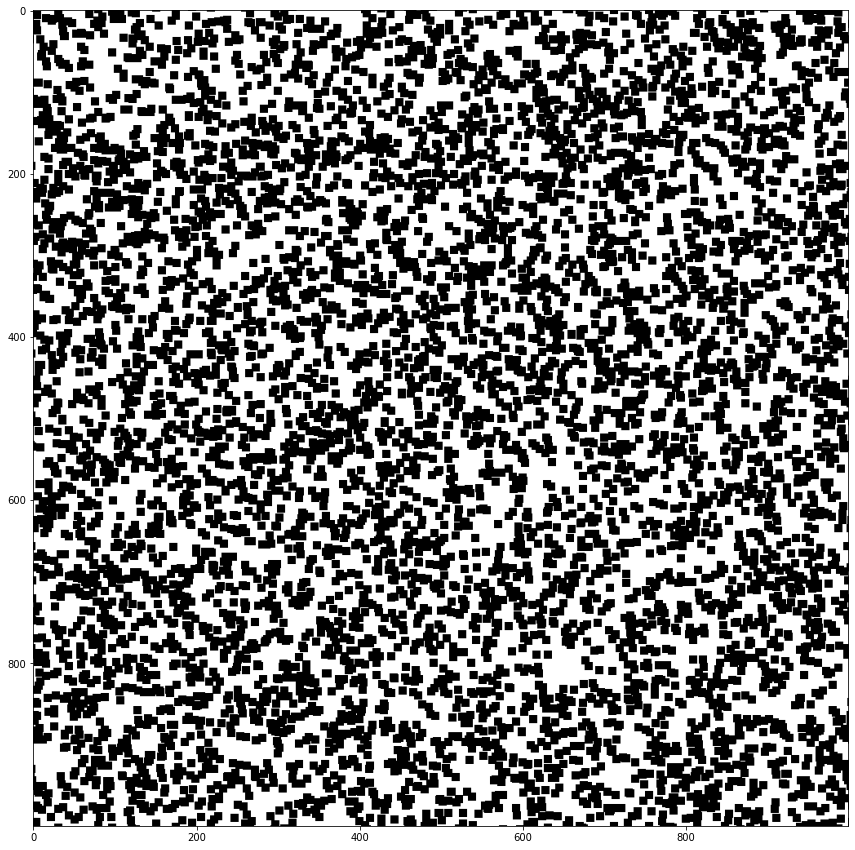

In [94]:
plt.figure(figsize=(15,15))
plt.imshow(mat, cmap='binary')
plt.show()

In [6]:
np.random.seed(420)
length = 10
frac = 0.5
scale = 2
tor_no = int(length*length*(1-frac)/(scale**2))
tor_dens = tor_no/(length*length)

print(f'Tor Number: {tor_no}')
print(f'Tor Density: {tor_dens}')

Tor Number: 12
Tor Density: 0.12


In [57]:
np.random.seed(420)
length = 10
frac = 0.2
scale = 2
tor_no = int(length*length*(1-frac)/(scale**2))
tor_dens = tor_no/(length*length)

z = np.zeros((length, length)) # do we really need this?
z += np.random.random_sample((length, length))

z[z <= (1-tor_dens)] = 0
z[z > (1-tor_dens)] = 1
print(z)
z = kernel(ksize=scale, arr=z)
print('\n\n', z)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
 [1. 1. 0. 1. 0. 0. 1. 0. 0. 0.]]


 [[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [60]:
r = (1-frac)/(0.00000000001+np.sum(z)/(length**2))
round(tor_no*r)

31

In [61]:
round(tor_no*r)/(length*length)

0.31

In [24]:
z

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
       [1., 1., 0., 1., 0., 0., 1., 0., 0., 0.]])

In [28]:
np.sum(z)/length**2

0.16

In [30]:
np.sum(z)

16.0

In [29]:
length**2

100

In [25]:
(1-frac)/(0.00000000001+np.sum(z)/(length**2))

4.9999999996875

In [14]:
(1-frac)/0

ZeroDivisionError: float division by zero

In [ ]:
z = np.zeros((length,length))
np.random.seed(seed_no)
z += np.random.rand(length,length) 

In [ ]:
# Example usage
length = 100
frac = 0.5
scale = 5
seed_no = 42

bedrock_map = tor_location(length, frac, scale, seed_no)

In [5]:
# Calculate tor_no and tor_dens directly in a single line
tor_no, tor_dens = int(length*length*(1-frac)/(scale**2)), int(length*length*(1-frac)/(scale**2))/(length*length)

# Generate random matrix and assign values based on condition in a single line
znew = np.where(np.random.random_sample((length, length)) > (1-tor_dens), 1, 0)


In [ ]:
import numpy as np

def create_matrix(frac, length):
    """
    Create a numpy matrix of dimension length x length with the 1's equal to the 
    fraction times length x length and 0's in the remainder. The 1's are uniformly
    randomly placed in the matrix.

    Parameters:
    frac (float): Fraction of 1's in the matrix. Should be between 0 and 1.
    length (int): The length of the sides of the matrix.

    Returns:
    np.ndarray: The resulting matrix.
    """
    # Calculate the total number of elements in the matrix
    total_elements = length * length

    # Calculate the number of 1's and 0's
    num_ones = int(frac * total_elements)
    num_zeros = total_elements - num_ones

    # Create a 1D array with the correct number of 1's and 0's
    arr = np.hstack([np.ones(num_ones, dtype=int), np.zeros(num_zeros, dtype=int)])

    # Shuffle the array to ensure the 1's are randomly placed
    np.random.shuffle(arr)

    # Reshape the 1D array into a 2D matrix of the required dimensions
    matrix = arr.reshape(length, length)

    return matrix
